# # Assignment 1 - Training an MLP on MNIST

Sven Den Hartog, 

Denise Klep, s4210646

In [44]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu
from chainer import serializers
import matplotlib.pyplot as plt
import utils

In [45]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

The model we use is a multilayered perceptron (MLP) with one hidden layer of 10 hidden neurons and 10 output neurons.
The amount of input units is inferred from the amount of pixels in each image of the trainings data (28 * 28 = 784 input units).

In [46]:
model = MLP(n_units=10, n_out=10)
optimizer = optimizers.SGD()
optimizer.setup(model)

We use stochastic gradient descent to optimize the model.

In [47]:
max_epoch = 20
batchsize = 32

train, test = utils.get_mnist(n_train=100, n_test=100)
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
mean_acc = [] 
mean_test_loss = [] 
mean_train_loss = []
train_losses = [] #made before the training loop to keep track of training loss values per batch

We train 20 epochs with batches of size 32 of the MNIST dataset. The 'mean' arrays keep track of the loss and accuracy per epoch.

In [48]:
while train_iter.epoch < max_epoch:

    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch) 
    #batch conversion function to change batch into image and target arrays suitable for the network

    prediction_train = model(image_train)

    loss = F.softmax_cross_entropy(prediction_train, target_train)
    train_losses.append(loss.data)

    model.cleargrads()
    loss.backward()

    optimizer.update()
    if train_iter.is_new_epoch:

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch) 

            prediction_test = model(image_test)

            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break
                #get out of test loop if test epoch completed

        mean_acc.append(np.mean(test_accuracies))
        mean_test_loss.append(np.mean(test_losses))
        mean_train_loss.append(np.mean(train_losses))
        #track mean losses for visualization later
        train_losses = []

Training loop. Here we loop each epoch over each mini training batch, calculate the predicted digit value and the loss, and update weights accordingly. Then if the epoch has been completed, i.e. the training loop has gone over all the mini batches, we loop over the mini test batch to calculate the predicted digit value and loss (without updating weights this time, to see how good it performs on 'new' images). 

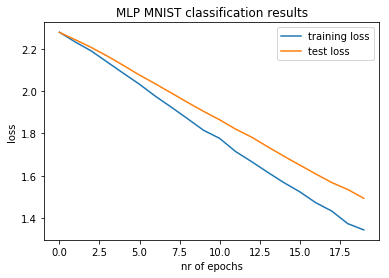

In [49]:
#visualize results for training and test loss values over the epochs
plt.xlabel('nr of epochs')
plt.ylabel('loss')
epochs = range(0,np.size(mean_acc))
plt.plot(epochs,mean_train_loss,
         label='training loss')
plt.plot(epochs,mean_test_loss,
         label='test loss')
plt.legend(loc='upper right')
plt.title('MLP MNIST classification results')
plt.show()

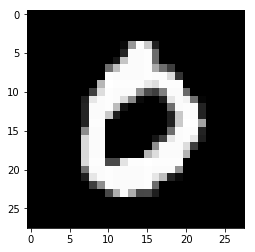

label: 0
predicted label: 9


In [50]:
#visualize first digit from test set
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)
x = x[None, ...]
y = model(x)
y = y.data

pred_label = y.argmax(axis=1)
print('predicted label:', pred_label[0])